In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/leslie_derti_apadb_features_pas_3_utr3.csv', sep='\t')

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_saluki_pmirGLO_construct_dense_full.npz")
hl, hl_m = save_dict['hl'], save_dict['hl_m']

a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAAAAAAA|AAAAAAGAAAAAA|AAAAAACAAAAAA")

#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type = 'apadb_count_pooled'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

model_names = [
    'aparent-resnet',
    'aparent-resnet+hl',
    'aparent',
    'deerect-apa',
    'polyapred',
]

model_scores = [
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_theano_legacy_30_31_34_pasaligned_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_deerect_apa_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_polyapred_native_scores_shifted.npy'),
]

use_saluki = [
    False,
    True,
    False,
    False,
    False,
]

print("s.shape = " + str(model_scores[0].shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))
print("a_rich.shape = " + str(hl_m.shape))


s.shape = (6944, 10)
m.shape = (6944, 10)
l.shape = (6944, 10)
y.shape = (6944, 10)
c.shape = (6944, 10)

hl.shape = (6944, 10, 50, 64)
hl_m.shape = (6944, 10)
a_rich.shape = (6944, 10)


In [3]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 10

m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :max_n_pas]
hl = hl[:, :max_n_pas]
hl_m = hl_m[:, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

m_cons = (np.sum(m, axis=-1) == np.sum(hl_m, axis=-1))

has_a_rich = np.sum(a_rich, axis=-1)

for model_ix in range(len(model_scores)) :
    model_scores[model_ix] = model_scores[model_ix][((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]

m = m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
l = l[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
c = c[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl = hl[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl_m = hl_m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]

pseudo_count = 0.1

y = c / np.sum(c, axis=1, keepdims=True)
y[np.isnan(y)] = 0.

y_pseudo = (c + pseudo_count) / np.sum((c + pseudo_count) * m, axis=1, keepdims=True)
y_pseudo[np.isnan(y_pseudo)] = 0.

print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(model_scores[0].shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))


m.shape = (5640, 10)
l.shape = (5640, 10)
c.shape = (5640, 10)
y.shape = (5640, 10)
s.shape = (5640, 10)

hl.shape = (5640, 10, 50, 64)
hl_m.shape = (5640, 10)


In [4]:
#Reduce half-life feature dims with PCA

from sklearn.decomposition import PCA

pcas = []
hl_pcas = []

for model_ix in range(hl.shape[2]) :

    flat_hl = np.array(np.reshape(hl[..., model_ix, :], (hl.shape[0] * hl.shape[1], hl.shape[3])), dtype=np.float32)
    flat_hl_m = np.array(np.reshape(hl_m, (hl.shape[0] * hl.shape[1],)), dtype=np.float32)

    pca = PCA(n_components=4).fit(flat_hl[flat_hl_m >= 1., ...])

    print("Model " + str(model_ix) + ", Fraction of variance explaned = " + str(round(np.sum(pca.explained_variance_ratio_), 3)))

    flat_hl_pca = pca.transform(flat_hl) * flat_hl_m[:, None]
    hl_pca = np.reshape(flat_hl_pca, (hl.shape[0], hl.shape[1], flat_hl_pca.shape[1]))

    print(hl_pca.shape)
    
    pcas.append(pca)
    hl_pcas.append(hl_pca)


Model 0, Fraction of variance explaned = 0.963
(5640, 10, 4)
Model 1, Fraction of variance explaned = 0.98
(5640, 10, 4)
Model 2, Fraction of variance explaned = 0.982
(5640, 10, 4)
Model 3, Fraction of variance explaned = 0.972
(5640, 10, 4)
Model 4, Fraction of variance explaned = 0.971
(5640, 10, 4)
Model 5, Fraction of variance explaned = 0.957
(5640, 10, 4)
Model 6, Fraction of variance explaned = 0.973
(5640, 10, 4)
Model 7, Fraction of variance explaned = 0.972
(5640, 10, 4)
Model 8, Fraction of variance explaned = 0.967
(5640, 10, 4)
Model 9, Fraction of variance explaned = 0.981
(5640, 10, 4)
Model 10, Fraction of variance explaned = 0.983
(5640, 10, 4)
Model 11, Fraction of variance explaned = 0.975
(5640, 10, 4)
Model 12, Fraction of variance explaned = 0.981
(5640, 10, 4)
Model 13, Fraction of variance explaned = 0.972
(5640, 10, 4)
Model 14, Fraction of variance explaned = 0.97
(5640, 10, 4)
Model 15, Fraction of variance explaned = 0.976
(5640, 10, 4)
Model 16, Fraction o

In [5]:

orig_l = np.copy(l)

#l = np.log(l * m + 1.)
l = np.log(np.cumsum(l, axis=1) * m + 1.)
#l = np.log(np.cumsum(l[:, ::-1], axis=1)[:, ::-1] * m + 1.)


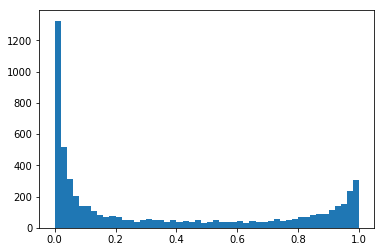

In [6]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist_pseudo = []
for i in range(y.shape[0]) :
    y_dist_pseudo.append(y_pseudo[i, dist_index[i]])

y_dist = np.array(y_dist)
y_dist_pseudo = np.array(y_dist_pseudo)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [7]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


Evaluating model = 'aparent-resnet'
fold = 0...
[ 0.80274943 -0.0452197  -5.12698379  0.85995417 -0.09039907 -4.75263374
  0.          0.        ]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.708
AP = 0.8
n = 5640


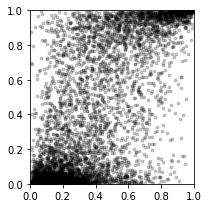

Evaluating model = 'aparent-resnet+hl'
fold = 0...
[ 0.92859784  0.01541357 -5.07227723  0.79141703 -0.04376621 -6.43766891
  0.06605293  0.06423019  3.62047806 -1.16287483  0.12480096  1.16128439
  3.88350948 -2.10747774]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.755
AP = 0.84
n = 5640


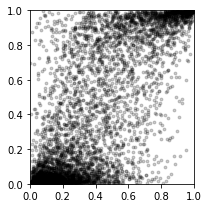

Evaluating model = 'aparent'
fold = 0...
[  0.55503867  -0.03814733 -11.44045758   0.51527788  -0.05391195
 -22.75905671   0.           0.        ]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.643
AP = 0.75
n = 5640


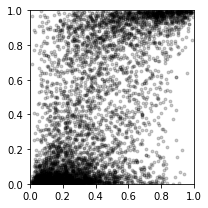

Evaluating model = 'deerect-apa'
fold = 0...
[ 3.91267848e-01 -5.87085506e-02 -1.26796288e+01  6.57791139e-01
  5.60628047e-03 -2.77768947e+01  0.00000000e+00  0.00000000e+00]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.501
AP = 0.64
n = 5640


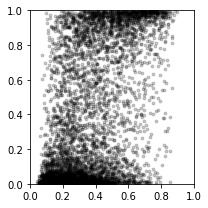

Evaluating model = 'polyapred'
fold = 0...
[  0.24711928  -0.06359512 -11.01141631   0.30881281  -0.04056405
 -12.75802485   0.           0.        ]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.446
AP = 0.59
n = 5640


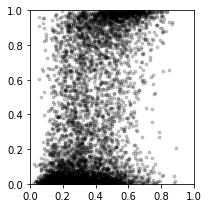

In [8]:
#Fit and evaluate regression / classification models on native measures

def logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask) :

    prox_exp = np.exp(w_prox_pas * s + np.sum(w_prox_hl[None, None, :] * hl, axis=-1) + w_prox_len * l)
    dist_exp = np.exp(w_dist_pas * s + np.sum(w_dist_hl[None, None, :] * hl, axis=-1) + w_dist_len * l)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1) + np.exp(w_prox_bias)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1) + np.exp(w_dist_bias)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, hl, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_len = w_bundle[1]
    w_prox_bias = w_bundle[2]
    w_dist_pas = w_bundle[3]
    w_dist_len = w_bundle[4]
    w_dist_bias = w_bundle[5]
    w_prox_hl = w_bundle[6:6+4] if w_bundle.shape[0] > 8 else w_bundle[6:7]
    w_dist_hl = w_bundle[6+4:6+8] if w_bundle.shape[0] > 8 else w_bundle[7:8]
    
    y_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

from sklearn.model_selection import KFold

def cross_val_model(s, hls, m, l, dist_mask, y_true, use_saluki=False, n_folds=10) :
    
    kf = KFold(n_splits=n_folds)
    
    y_pred = np.zeros(y_true.shape)
    
    for fold_ix, [train_index, test_index] in enumerate(kf.split(s)) :
        
        print("fold = " + str(fold_ix) + "...")
        
        for hl_ix, hl in enumerate(hls) :
        
            s_train, s_test = s[train_index], s[test_index]
            hl_train, hl_test = hl[train_index], hl[test_index]
            m_train, m_test = m[train_index], m[test_index]
            l_train, l_test = l[train_index], l[test_index]
            dist_mask_train, dist_mask_test = dist_mask[train_index], dist_mask[test_index]
            y_true_train = y_true[train_index]

            w0 = np.zeros(6 + (8 if use_saluki else 2))

            res = minimize(logistic_model_mse, w0, args=(s_train, hl_train if use_saluki else 0., m_train, l_train, dist_mask_train, y_true_train), method='BFGS', options={'disp': False})

            w_prox_pas = res.x[0]
            w_prox_len = res.x[1]
            w_prox_bias = res.x[2]
            w_dist_pas = res.x[3]
            w_dist_len = res.x[4]
            w_dist_bias = res.x[5]
            w_prox_hl = res.x[6:6+4] if use_saluki else res.x[6:7]
            w_dist_hl = res.x[6+4:6+8] if use_saluki else res.x[7:8]

            if fold_ix == 0 and hl_ix == 0 :
                print(res.x)

            y_pred[test_index] += logistic_model_predict(s_test, hl_test if use_saluki else 0., m_test, l_test, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask_test)

            if not use_saluki :
                break
            
        if use_saluki :
            y_pred[test_index] /= float(len(hls))
        
    return y_pred

model_spearman_rs = np.zeros(len(model_scores))
model_aps = np.zeros(len(model_scores))
model_y_dist_preds = np.zeros((y_dist.shape[0], len(model_scores)))

for model_ix in range(len(model_scores)) :
    
    print("Evaluating model = '" + model_names[model_ix] + "'")
    
    s = model_scores[model_ix]
    
    y_dist_pred = cross_val_model(s, hl_pcas, m, l, dist_mask, y_dist, use_saluki=use_saluki[model_ix], n_folds=20)
    
    spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)
    model_spearman_rs[model_ix] = spearman_r_val
    
    y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])
    
    ap = average_precision_score(y_labels, y_dist_pred)
    model_aps[model_ix] = ap
    model_y_dist_preds[:, model_ix] = y_dist_pred[:]

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_dist.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [13]:
#Save metrics

np.save("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_spearman_rs", model_spearman_rs)
np.save("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_aps", model_aps)
np.save("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_y_dist_preds", model_y_dist_preds)
np.save("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_orig_l", orig_l)
np.save("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_y_dist", y_dist)
np.save("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_y_dist_pseudo", y_dist_pseudo)


In [19]:
#Load metrics

model_spearman_rs_apadb = np.load("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_spearman_rs.npy")
model_aps_apadb = np.load("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_aps.npy")
model_y_dist_preds_apadb = np.load("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_y_dist_preds.npy")
model_orig_l_apadb = np.load("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_orig_l.npy")
model_hl_apadb = np.load("native_apa_multi_apadb_w_saluki_cv_20_hl.npy")
model_y_dist_apadb = np.load("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_y_dist.npy")
model_y_dist_apadb_pseudo = np.load("native_apa_multi_apadb_w_saluki_dense_all_folds_cv_20_y_dist_pseudo.npy")

model_spearman_rs_polyadb = np.load("native_apa_multi_polyadb_w_saluki_dense_all_folds_cv_20_spearman_rs.npy")
model_aps_polyadb = np.load("native_apa_multi_polyadb_w_saluki_dense_all_folds_cv_20_aps.npy")
model_y_dist_preds_polyadb = np.load("native_apa_multi_polyadb_w_saluki_dense_all_folds_cv_20_y_dist_preds.npy")
model_orig_l_polyadb = np.load("native_apa_multi_polyadb_w_saluki_dense_all_folds_cv_20_orig_l.npy")
model_hl_polyadb = np.load("native_apa_multi_polyadb_w_saluki_cv_20_hl.npy")
model_y_dist_polyadb = np.load("native_apa_multi_polyadb_w_saluki_dense_all_folds_cv_20_y_dist.npy")
model_y_dist_polyadb_pseudo = np.load("native_apa_multi_polyadb_w_saluki_dense_all_folds_cv_20_y_dist.npy")

model_spearman_rs_leslie = np.load("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_spearman_rs.npy")
model_aps_leslie = np.load("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_aps.npy")
model_y_dist_preds_leslie = np.load("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_y_dist_preds.npy")
model_orig_l_leslie = np.load("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_orig_l.npy")
model_hl_leslie = np.load("native_apa_multi_leslie_w_saluki_cv_20_hl.npy")
model_y_dist_leslie = np.load("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_y_dist.npy")
model_y_dist_leslie_pseudo = np.load("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_y_dist_pseudo.npy")

model_spearman_rs_derti = np.load("native_apa_multi_derti_w_saluki_dense_all_folds_cv_20_spearman_rs.npy")
model_aps_derti = np.load("native_apa_multi_derti_w_saluki_dense_all_folds_cv_20_aps.npy")
model_y_dist_preds_derti = np.load("native_apa_multi_derti_w_saluki_dense_all_folds_cv_20_y_dist_preds.npy")
model_orig_l_derti = np.load("native_apa_multi_derti_w_saluki_dense_all_folds_cv_20_orig_l.npy")
model_hl_derti = np.load("native_apa_multi_derti_w_saluki_cv_20_hl.npy")
model_y_dist_derti = np.load("native_apa_multi_derti_w_saluki_dense_all_folds_cv_20_y_dist.npy")
model_y_dist_derti_pseudo = np.load("native_apa_multi_derti_w_saluki_dense_all_folds_cv_20_y_dist_pseudo.npy")


APADB  Spearman r = [0.708, 0.755, 0.643, 0.501, 0.446]
Leslie Spearman r = [0.671, 0.709, 0.595, 0.481, 0.419]
Derti  Spearman r = [0.601, 0.626, 0.601, 0.371, 0.356]

APADB  Count = 5640
Leslie Count = 5546
Derti  Count = 5442


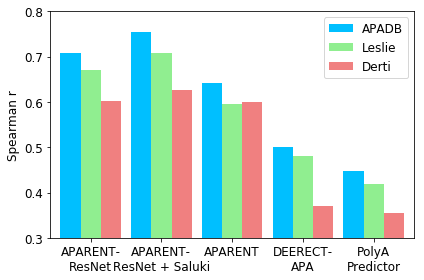

APADB  AP = [0.802, 0.845, 0.754, 0.643, 0.592]
Leslie AP = [0.807, 0.841, 0.747, 0.655, 0.59]
Derti  AP = [0.735, 0.756, 0.731, 0.58, 0.558]


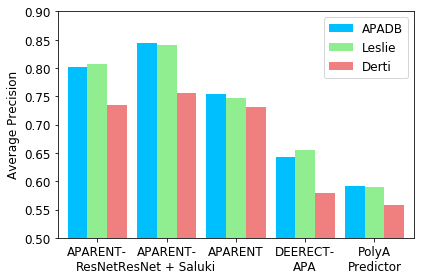

In [20]:

print("APADB  Spearman r = " + str(np.round(model_spearman_rs_apadb, 3).tolist()))
print("Leslie Spearman r = " + str(np.round(model_spearman_rs_leslie, 3).tolist()))
print("Derti  Spearman r = " + str(np.round(model_spearman_rs_derti, 3).tolist()))
print("")

print("APADB  Count = " + str(model_y_dist_apadb.shape[0]))
print("Leslie Count = " + str(model_y_dist_leslie.shape[0]))
print("Derti  Count = " + str(model_y_dist_derti.shape[0]))

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(model_spearman_rs_apadb.shape[0]) * 3.5, model_spearman_rs_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_spearman_rs_leslie.shape[0]) * 3.5 + 1, model_spearman_rs_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_spearman_rs_derti.shape[0]) * 3.5 + 2, model_spearman_rs_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 17)
plt.ylim(0.3, 0.8)

plt.xticks([1, 4.5, 8, 11.5, 15], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Spearman r', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_eval_bars_spearman_r.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_eval_bars_spearman_r.eps")

plt.show()


print("APADB  AP = " + str(np.round(model_aps_apadb, 3).tolist()))
print("Leslie AP = " + str(np.round(model_aps_leslie, 3).tolist()))
print("Derti  AP = " + str(np.round(model_aps_derti, 3).tolist()))

f = plt.figure(figsize=(6, 4))

plt.bar(np.arange(model_aps_apadb.shape[0]) * 3.5, model_aps_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_aps_leslie.shape[0]) * 3.5 + 1, model_aps_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_aps_derti.shape[0]) * 3.5 + 2, model_aps_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 17)
plt.ylim(0.5, 0.9)

plt.xticks([1, 4.5, 8, 11.5, 15], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Average Precision', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_eval_bars_ap.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_eval_bars_ap.eps")

plt.show()


--- Short vs. Long Isoform ---
- <= 250, r = 0.002 (n = 790)
-  > 250, r = 0.053 (n = 4850)


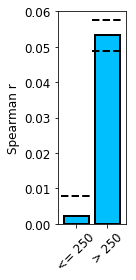

--- Short vs. Mid vs. Long Isoform ---
- <= 250, r = 0.002 (n = 790)
- (250, 750], r = 0.033 (n = 1263)
-  > 750, r = 0.056 (n = 3587)


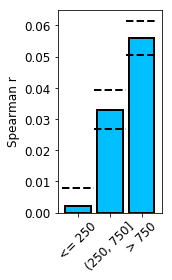

--- Short vs. Long Isoform vs. High HL Diff ---
- L <= 250, r = 0.002 (n = 790)
- L  > 250, r = 0.053 (n = 4850)
- HL > 1.5, r = 0.087 (n = 196)


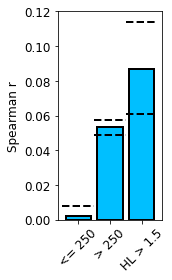

In [9]:
#Analyze improvement of Saluki, summarized bar charts (length & differential stability)

def _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index, n_bootstrap=10000, low_q=0.1, high_q=0.9) :
    
    r_bootstraps = []
    for bootstrap_ix in range(n_bootstrap) :
        sel_index = np.nonzero(keep_index)[0].tolist()
        sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)

        r_bootstraps.append(spearmanr(y_dist_pred[sel_index], y_dist[sel_index])[0] - spearmanr(y_dist_pred_old[sel_index], y_dist[sel_index])[0])
    
    return np.quantile(r_bootstraps, q=low_q), np.median(r_bootstraps), np.quantile(r_bootstraps, q=high_q)

model_y_dist_pred = model_y_dist_preds_apadb
y_dist = model_y_dist_apadb
orig_l = model_orig_l_apadb
hl = model_hl_apadb
data_name = "APADB"
data_color = "deepskyblue"

y_dist_pred_old = model_y_dist_pred[:, 0]
y_dist_pred = model_y_dist_pred[:, 1]

#Short vs. Long Isoform
isoform_len_cutoff = 250

keep_index = (np.max(orig_l, axis=-1) <= isoform_len_cutoff)
n_short = np.sum(keep_index)
r_short = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_short_low, r_short_median, r_short_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

keep_index = (np.max(orig_l, axis=-1) > isoform_len_cutoff)
n_long = np.sum(keep_index)
r_long = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_long_low, r_long_median, r_long_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

print("--- Short vs. Long Isoform ---")

print("- <= " + str(isoform_len_cutoff) + ", r = " + str(round(r_short, 3)) + " (n = " + str(n_short) + ")")
print("-  > " + str(isoform_len_cutoff) + ", r = " + str(round(r_long, 3)) + " (n = " + str(n_long) + ")")

f = plt.figure(figsize=(2, 4))

plt.bar([0, 1], [r_short, r_long], width=0.8, color=data_color, edgecolor='black', linewidth=2)

plt.plot([-0.5, 0.5], [r_short_low, r_short_low], linewidth=2, linestyle='--', color='black')
plt.plot([-0.5, 0.5], [r_short_high, r_short_high], linewidth=2, linestyle='--', color='black')

plt.plot([0.5, 1.5], [r_long_low, r_long_low], linewidth=2, linestyle='--', color='black')
plt.plot([0.5, 1.5], [r_long_high, r_long_high], linewidth=2, linestyle='--', color='black')

plt.ylim(0.0, 0.06)

plt.xticks([0, 1], ["<= " + str(isoform_len_cutoff), "> " + str(isoform_len_cutoff)], fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.ylabel("Spearman r" , fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_distance_bar.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_distance_bar.eps")

plt.show()

#Short vs. Mid vs. Long Isoform
isoform_len_cutoff_1 = 250
isoform_len_cutoff_2 = 750

keep_index = (np.max(orig_l, axis=-1) <= isoform_len_cutoff_1)
n_short = np.sum(keep_index)
r_short = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_short_low, r_short_median, r_short_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

keep_index = (np.max(orig_l, axis=-1) > isoform_len_cutoff_1) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff_2)
n_mid = np.sum(keep_index)
r_mid = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_mid_low, r_mid_median, r_mid_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

keep_index = (np.max(orig_l, axis=-1) > isoform_len_cutoff_2)
n_long = np.sum(keep_index)
r_long = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_long_low, r_long_median, r_long_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

print("--- Short vs. Mid vs. Long Isoform ---")

print("- <= " + str(isoform_len_cutoff_1) + ", r = " + str(round(r_short, 3)) + " (n = " + str(n_short) + ")")
print("- (" + str(isoform_len_cutoff_1) + ", " + str(isoform_len_cutoff_2) + "], r = " + str(round(r_mid, 3)) + " (n = " + str(n_mid) + ")")
print("-  > " + str(isoform_len_cutoff_2) + ", r = " + str(round(r_long, 3)) + " (n = " + str(n_long) + ")")

f = plt.figure(figsize=(2.5, 4))

plt.bar([0, 1, 2], [r_short, r_mid, r_long], width=0.8, color=data_color, edgecolor='black', linewidth=2)

plt.plot([-0.5, 0.5], [r_short_low, r_short_low], linewidth=2, linestyle='--', color='black')
plt.plot([-0.5, 0.5], [r_short_high, r_short_high], linewidth=2, linestyle='--', color='black')

plt.plot([0.5, 1.5], [r_mid_low, r_mid_low], linewidth=2, linestyle='--', color='black')
plt.plot([0.5, 1.5], [r_mid_high, r_mid_high], linewidth=2, linestyle='--', color='black')

plt.plot([1.5, 2.5], [r_long_low, r_long_low], linewidth=2, linestyle='--', color='black')
plt.plot([1.5, 2.5], [r_long_high, r_long_high], linewidth=2, linestyle='--', color='black')

plt.ylim(0.0, 0.065)

plt.xticks([0, 1, 2], ["<= " + str(isoform_len_cutoff_1), "(" + str(isoform_len_cutoff_1) + ", " + str(isoform_len_cutoff_2) + "]", "> " + str(isoform_len_cutoff_2),], fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.ylabel("Spearman r" , fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_distance_bar_detailed.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_distance_bar_detailed.eps")

plt.show()

#Short vs. Long Isoform vs. High HL Diff
isoform_len_cutoff = 250
diff_hl_cutoff = 1.5

keep_index = (np.max(orig_l, axis=-1) <= isoform_len_cutoff)
n_short = np.sum(keep_index)
r_short = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_short_low, r_short_median, r_short_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

keep_index = (np.max(orig_l, axis=-1) > isoform_len_cutoff)
n_long = np.sum(keep_index)
r_long = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_long_low, r_long_median, r_long_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) > diff_hl_cutoff) & (np.max(orig_l, axis=-1) > isoform_len_cutoff)
n_high = np.sum(keep_index)
r_high = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_high_low, r_high_median, r_high_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

print("--- Short vs. Long Isoform vs. High HL Diff ---")

print("- L <= " + str(isoform_len_cutoff) + ", r = " + str(round(r_short, 3)) + " (n = " + str(n_short) + ")")
print("- L  > " + str(isoform_len_cutoff) + ", r = " + str(round(r_long, 3)) + " (n = " + str(n_long) + ")")
print("- HL > " + str(diff_hl_cutoff) + ", r = " + str(round(r_high, 3)) + " (n = " + str(n_high) + ")")

f = plt.figure(figsize=(2.5, 4))

plt.bar([0, 1, 2], [r_short, r_long, r_high], width=0.8, color=data_color, edgecolor='black', linewidth=2)

plt.plot([-0.5, 0.5], [r_short_low, r_short_low], linewidth=2, linestyle='--', color='black')
plt.plot([-0.5, 0.5], [r_short_high, r_short_high], linewidth=2, linestyle='--', color='black')

plt.plot([0.5, 1.5], [r_long_low, r_long_low], linewidth=2, linestyle='--', color='black')
plt.plot([0.5, 1.5], [r_long_high, r_long_high], linewidth=2, linestyle='--', color='black')

plt.plot([1.5, 2.5], [r_high_low, r_high_low], linewidth=2, linestyle='--', color='black')
plt.plot([1.5, 2.5], [r_high_high, r_high_high], linewidth=2, linestyle='--', color='black')

plt.ylim(0.0, 0.12)

plt.xticks([0, 1, 2], ["<= " + str(isoform_len_cutoff), "> " + str(isoform_len_cutoff), "HL > " + str(diff_hl_cutoff)], fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.ylabel("Spearman r" , fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_distance_bar_hl_diff.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_distance_bar_hl_diff.eps")

plt.show()


use_are.shape = (5640, 10)
use_pum.shape = (5640, 10)
--- No Motif vs. PUM Hit vs. ARE Hit ---
- No Motif,  r = 0.045 (n = 4676)
- PUM Hit, r = 0.068 (n = 417)
- ARE Hit, r = 0.068 (n = 619)


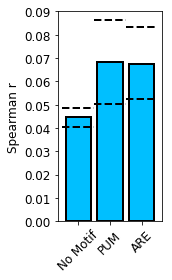

In [10]:
#Analyze improvement of Saluki, summarized bar charts (motifs)

model_y_dist_pred = model_y_dist_preds_apadb
y_dist = model_y_dist_apadb
orig_l = model_orig_l_apadb
hl = model_hl_apadb
data_name = "APADB"
data_color = "deepskyblue"

#Map upstream ARE- and PUM binding motifs to PASes
use_are = np.zeros((len(df), m.shape[1]))
use_pum = np.zeros((len(df), m.shape[1]))
for k in range(m.shape[1]) :
    use_are[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 100, 175).str.count("TATTTAT")
    use_pum[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 100, 175).str.count("TGTAAATA|TGTATATA")

use_are = use_are[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
use_pum = use_pum[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]

print("use_are.shape = " + str(use_are.shape))
print("use_pum.shape = " + str(use_pum.shape))

y_dist_pred_old = model_y_dist_pred[:, 0]
y_dist_pred = model_y_dist_pred[:, 1]

#No Motif vs. Motif Hit
isoform_len_cutoff = 40000

keep_index = (np.sum((use_pum + use_are) * (1. - dist_mask) * m, axis=-1) <= 0.) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)
n_miss = np.sum(keep_index)
r_miss = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_miss_low, r_miss_median, r_miss_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

keep_index = (np.sum(use_pum * (1. - dist_mask) * m, axis=-1) >= 1.) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)
n_pum = np.sum(keep_index)
r_pum = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_pum_low, r_pum_median, r_pum_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

keep_index = (np.sum(use_are * (1. - dist_mask) * m, axis=-1) >= 1.) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)
n_are = np.sum(keep_index)
r_are = spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0]
r_are_low, r_are_median, r_are_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)

print("--- No Motif vs. PUM Hit vs. ARE Hit ---")

print("- No Motif,  r = " + str(round(r_miss, 3)) + " (n = " + str(n_miss) + ")")
print("- PUM Hit, r = " + str(round(r_pum, 3)) + " (n = " + str(n_pum) + ")")
print("- ARE Hit, r = " + str(round(r_are, 3)) + " (n = " + str(n_are) + ")")

f = plt.figure(figsize=(2.5, 4))

plt.bar([0, 1, 2], [r_miss, r_pum, r_are], width=0.8, color=data_color, edgecolor='black', linewidth=2)

plt.plot([-0.5, 0.5], [r_miss_low, r_miss_low], linewidth=2, linestyle='--', color='black')
plt.plot([-0.5, 0.5], [r_miss_high, r_miss_high], linewidth=2, linestyle='--', color='black')

plt.plot([0.5, 1.5], [r_pum_low, r_pum_low], linewidth=2, linestyle='--', color='black')
plt.plot([0.5, 1.5], [r_pum_high, r_pum_high], linewidth=2, linestyle='--', color='black')

plt.plot([1.5, 2.5], [r_are_low, r_are_low], linewidth=2, linestyle='--', color='black')
plt.plot([1.5, 2.5], [r_are_high, r_are_high], linewidth=2, linestyle='--', color='black')

plt.ylim(0.0, 0.09)

plt.xticks([0, 1, 2], ["No Motif", "PUM", "ARE"], fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.ylabel("Spearman r" , fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_motif_bar.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_motif_bar.eps")

plt.show()


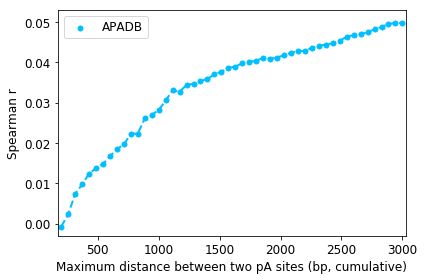

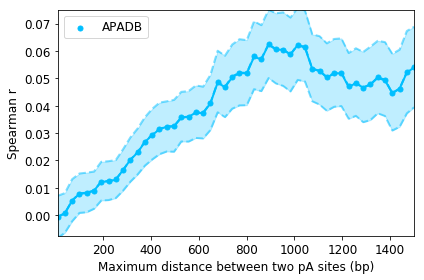

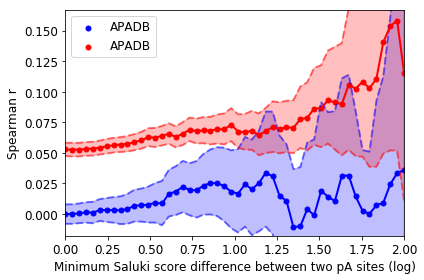

ns_vals_short_isoforms = [650 650 634 611 589 559 523 489 457 415 382 357 331 298 267 247 227 212
 202 186 172 161 150 137 123 112 101  93  87  76  70  63  59  53  49  41
  37  32  31  28  24  24  21  17  15  12  11  10   9   7]
ns_vals_long_isoforms = [4990 4976 4941 4884 4797 4648 4494 4288 4087 3845 3605 3348 3090 2847
 2613 2410 2207 2010 1833 1679 1519 1385 1257 1148 1036  912  800  718
  638  567  503  445  390  344  300  261  225  197  173  144  122  100
   83   75   66   55   37   29   28   23]


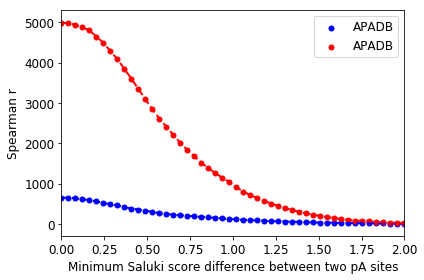

In [77]:
#Analyze improvement of Saluki, detailed line plots

def _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index, n_bootstrap=10000, low_q=0.05, high_q=0.95) :
    
    r_bootstraps = []
    for bootstrap_ix in range(n_bootstrap) :
        sel_index = np.nonzero(keep_index)[0].tolist()
        sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)

        r_bootstraps.append(spearmanr(y_dist_pred[sel_index], y_dist[sel_index])[0] - spearmanr(y_dist_pred_old[sel_index], y_dist[sel_index])[0])
    
    return np.quantile(r_bootstraps, q=low_q), np.median(r_bootstraps), np.quantile(r_bootstraps, q=high_q)

model_y_dist_pred = model_y_dist_preds_apadb
y_dist = model_y_dist_apadb
orig_l = model_orig_l_apadb
hl = model_hl_apadb
data_name = "APADB"
data_color = "deepskyblue"

y_dist_pred_old = model_y_dist_pred[:, 0]
y_dist_pred = model_y_dist_pred[:, 1]

#By maximum distance between two sites, cumulative up to a cutoff

max_l_cutoffs = np.linspace(200, 3000, 50)

f = plt.figure(figsize=(6, 4))

r_vals = []
for max_l_cutoff in max_l_cutoffs.tolist() :
    keep_index = np.max(orig_l, axis=-1) < max_l_cutoff

    r_vals.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

r_vals = np.array(r_vals)

plt.plot(max_l_cutoffs, r_vals, color=data_color, linewidth=2, linestyle='--')
plt.scatter(max_l_cutoffs, r_vals, s=25, color=data_color, label=data_name)

plt.xlim(170, 3030)
plt.ylim(-0.003)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Maximum distance between two pA sites (bp, cumulative)", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_max_distance_cumulative_curve.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_max_distance_cumulative_curve.eps")

plt.show()

#By maximum distance between two sites

max_l_cutoffs = np.linspace(10, 1500, 50)

f = plt.figure(figsize=(6, 4))

r_vals = []
r_vals_low = []
r_vals_median = []
r_vals_high = []
for max_l_cutoff in max_l_cutoffs.tolist() :
    keep_index = (np.max(orig_l, axis=-1) >= max_l_cutoff - 200) & (np.max(orig_l, axis=-1) < max_l_cutoff + 200)

    r_vals.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])
    
    r_val_low, r_val_median, r_val_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)
    r_vals_low.append(r_val_low)
    r_vals_median.append(r_val_median)
    r_vals_high.append(r_val_high)
    
r_vals = np.array(r_vals)

plt.plot(max_l_cutoffs, r_vals, color=data_color, linewidth=2, linestyle='--')
plt.scatter(max_l_cutoffs, r_vals, s=25, color=data_color, label=data_name)

plt.plot(max_l_cutoffs, r_vals_low, color=data_color, alpha=0.5, linewidth=2, linestyle='--')
plt.plot(max_l_cutoffs, r_vals_median, color=data_color, linewidth=2, linestyle='-')
plt.plot(max_l_cutoffs, r_vals_high, color=data_color, alpha=0.5, linewidth=2, linestyle='--')
plt.fill_between(max_l_cutoffs, r_vals_low, r_vals_high, color=data_color, alpha=0.25)

plt.xlim(10, 1500)
plt.ylim(-0.0075, 0.075)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Maximum distance between two pA sites (bp)", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_max_distance_curve.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_max_distance_curve.eps")

plt.show()

#By maximum difference in Saluki score (bootstrap)
isoform_len_cutoff = 200

diff_hl_cutoffs = np.linspace(0., 2.0, 50)

ns_short_isoforms = []
r_vals_short_isoforms = []
r_vals_short_isoforms_low = []
r_vals_short_isoforms_median = []
r_vals_short_isoforms_high = []
for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
    keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)

    ns_short_isoforms.append(np.sum(keep_index))
    r_vals_short_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    r_val_low, r_val_median, r_val_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)
    r_vals_short_isoforms_low.append(r_val_low)
    r_vals_short_isoforms_median.append(r_val_median)
    r_vals_short_isoforms_high.append(r_val_high)
    
ns_short_isoforms = np.array(ns_short_isoforms)
r_vals_short_isoforms = np.array(r_vals_short_isoforms)
r_vals_short_isoforms_low = np.array(r_vals_short_isoforms_low)
r_vals_short_isoforms_median = np.array(r_vals_short_isoforms_median)
r_vals_short_isoforms_high = np.array(r_vals_short_isoforms_high)

ns_long_isoforms = []
r_vals_long_isoforms = []
r_vals_long_isoforms_low = []
r_vals_long_isoforms_median = []
r_vals_long_isoforms_high = []
for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
    keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) > isoform_len_cutoff)

    ns_long_isoforms.append(np.sum(keep_index))
    r_vals_long_isoforms.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    r_val_low, r_val_median, r_val_high = _get_bootstrap_spearman_rs(y_dist_pred, y_dist_pred_old, y_dist, keep_index)
    r_vals_long_isoforms_low.append(r_val_low)
    r_vals_long_isoforms_median.append(r_val_median)
    r_vals_long_isoforms_high.append(r_val_high)
    
ns_long_isoforms = np.array(ns_long_isoforms)
r_vals_long_isoforms = np.array(r_vals_long_isoforms)
r_vals_long_isoforms_low = np.array(r_vals_long_isoforms_low)
r_vals_long_isoforms_median = np.array(r_vals_long_isoforms_median)
r_vals_long_isoforms_high = np.array(r_vals_long_isoforms_high)

f = plt.figure(figsize=(6, 4))

plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_low, color='blue', alpha=0.5, linewidth=2, linestyle='--')
plt.plot(diff_hl_cutoffs, r_vals_short_isoforms, color='blue', linewidth=2, linestyle='-')
plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_high, color='blue', alpha=0.5, linewidth=2, linestyle='--')
plt.fill_between(diff_hl_cutoffs, r_vals_short_isoforms_low, r_vals_short_isoforms_high, color='blue', alpha=0.25)
plt.scatter(diff_hl_cutoffs, r_vals_short_isoforms, s=25, color='blue', label=data_name)

plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_low, color='red', alpha=0.5, linewidth=2, linestyle='--')
plt.plot(diff_hl_cutoffs, r_vals_long_isoforms, color='red', linewidth=2, linestyle='-')
plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_high, color='red', alpha=0.5, linewidth=2, linestyle='--')
plt.fill_between(diff_hl_cutoffs, r_vals_long_isoforms_low, r_vals_long_isoforms_high, color='red', alpha=0.25)
plt.scatter(diff_hl_cutoffs, r_vals_long_isoforms, s=25, color='red', label=data_name)

#plt.xlim(-0.025, 2.025)
plt.xlim(0.0, 2.0)
plt.ylim(-0.018, 0.167)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Minimum Saluki score difference between two pA sites (log)", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_min_hl_curve_bootstrap.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_min_hl_curve_bootstrap.eps")

plt.show()

print("ns_vals_short_isoforms = " + str(ns_short_isoforms))
print("ns_vals_long_isoforms = " + str(ns_long_isoforms))

f = plt.figure(figsize=(6, 4))

plt.plot(diff_hl_cutoffs, ns_short_isoforms, color='blue', linewidth=2, linestyle='--')
plt.scatter(diff_hl_cutoffs, ns_short_isoforms, s=25, color='blue', label=data_name)

plt.plot(diff_hl_cutoffs, ns_long_isoforms, color='red', linewidth=2, linestyle='--')
plt.scatter(diff_hl_cutoffs, ns_long_isoforms, s=25, color='red', label=data_name)

#plt.xlim(-0.025, 2.025)
plt.xlim(0.0, 2.0)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Minimum Saluki score difference between two pA sites", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_min_hl_curve_count.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_min_hl_curve_count.eps")

plt.show()


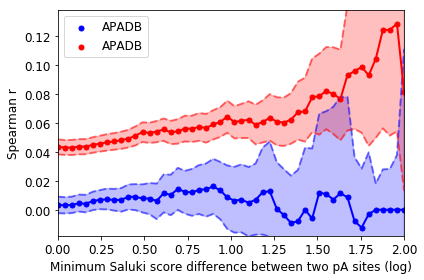

ns_vals_short_isoforms = [[790 788 771 745 719 684 641 605 563 512 473 444 411 373 333 309 284 266
  252 235 219 205 189 174 155 142 128 119 110  98  90  83  77  68  63  53
   47  41  39  36  32  31  27  22  20  16  13  11  10   7]
 [776 774 757 731 705 670 627 592 551 502 463 435 402 364 324 301 276 258
  245 229 213 200 185 170 151 138 126 118 109  97  89  82  76  67  62  52
   46  40  38  35  31  30  26  22  20  16  13  11  10   7]
 [744 742 726 702 676 642 599 566 526 478 439 416 385 349 311 290 265 248
  234 218 204 192 176 161 144 133 120 111 103  91  84  77  71  62  57  48
   42  36  34  31  28  27  23  19  17  13  11   9   8   5]]
ns_vals_long_isoforms = [[4850 4838 4804 4750 4667 4523 4376 4172 3981 3748 3514 3261 3010 2772
  2547 2348 2150 1956 1783 1630 1472 1341 1218 1111 1004  882  773  692
   615  545  483  425  372  329  286  249  215  188  165  136  114   93
    77   70   61   51   35   28   27   23]
 [4770 4760 4728 4675 4595 4453 4310 4112 3926 3700 3471 3221 2973 274

In [76]:
#Analyze improvement of Saluki, detailed line plots (median across all data sources, pseudo count-smoothed proportions)

def _get_bootstrap_spearman_rs_median_data_source(model_y_dist_preds, y_dists, keep_indices, n_bootstrap=10000, low_q=0.05, high_q=0.95) :
    
    r_bootstraps = []
    for bootstrap_ix in range(n_bootstrap) :
        
        r_data_sources = []
        for data_source_ix in range(len(model_y_dist_preds)) :
        
            keep_index = keep_indices[data_source_ix]
            y_dist_pred = model_y_dist_preds[data_source_ix][:, 1]
            y_dist_pred_old = model_y_dist_preds[data_source_ix][:, 0]
            y_dist = y_dists[data_source_ix]
        
            sel_index = np.nonzero(keep_index)[0].tolist()
            sel_index = np.random.choice(sel_index, size=(len(sel_index),), replace=True)

            if len(np.nonzero(keep_index)[0].tolist()) > 1 and np.std(y_dist_pred[sel_index]) > 0. and np.std(y_dist_pred_old[sel_index]) > 0. and np.std(y_dist[sel_index]) > 0. :
                r_data_sources.append(spearmanr(y_dist_pred[sel_index], y_dist[sel_index])[0] - spearmanr(y_dist_pred_old[sel_index], y_dist[sel_index])[0])
        
        r_bootstraps.append(np.median(r_data_sources))
    
    return np.quantile(r_bootstraps, q=low_q), np.median(r_bootstraps), np.quantile(r_bootstraps, q=high_q)

model_y_dist_preds = [model_y_dist_preds_apadb, model_y_dist_preds_leslie, model_y_dist_preds_derti]
y_dists = [model_y_dist_apadb_pseudo, model_y_dist_leslie_pseudo, model_y_dist_derti_pseudo]
orig_ls = [model_orig_l_apadb, model_orig_l_leslie, model_orig_l_derti]
hls = [model_hl_apadb, model_hl_leslie, model_hl_derti]
data_names = ["APADB", "Leslie", "Derti"]
data_colors = ["deepskyblue", "lightgreen", "lightcoral"]

#By maximum difference in Saluki score (bootstrap, median across data source)
isoform_len_cutoff = 250

diff_hl_cutoffs = np.linspace(0., 2.0, 50)

ns_short_isoforms = []
r_vals_short_isoforms = []
r_vals_short_isoforms_low = []
r_vals_short_isoforms_median = []
r_vals_short_isoforms_high = []
for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
    
    r_data_sources = []
    keep_indices = []
    for data_source_ix in range(len(model_y_dist_preds)) :
        y_dist_pred_old = model_y_dist_preds[data_source_ix][:, 0]
        y_dist_pred = model_y_dist_preds[data_source_ix][:, 1]
        
        y_dist = y_dists[data_source_ix]
        hl = hls[data_source_ix]
        orig_l = orig_ls[data_source_ix]
        
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) <= isoform_len_cutoff)
        keep_indices.append(keep_index)
    
        if len(np.nonzero(keep_index)[0].tolist()) > 1 :
            r_data_sources.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])
    
    ns_short_isoforms.append(np.array([np.sum(keep_indices[i]) for i in range(len(keep_indices))])[:, None])
    r_vals_short_isoforms.append(np.median(r_data_sources))
    
    r_val_low, r_val_median, r_val_high = _get_bootstrap_spearman_rs_median_data_source(model_y_dist_preds, y_dists, keep_indices)
    r_vals_short_isoforms_low.append(r_val_low)
    r_vals_short_isoforms_median.append(r_val_median)
    r_vals_short_isoforms_high.append(r_val_high)
    
ns_short_isoforms = np.concatenate(ns_short_isoforms, axis=-1)
r_vals_short_isoforms = np.array(r_vals_short_isoforms)
r_vals_short_isoforms_low = np.array(r_vals_short_isoforms_low)
r_vals_short_isoforms_median = np.array(r_vals_short_isoforms_median)
r_vals_short_isoforms_high = np.array(r_vals_short_isoforms_high)

ns_long_isoforms = []
r_vals_long_isoforms = []
r_vals_long_isoforms_low = []
r_vals_long_isoforms_median = []
r_vals_long_isoforms_high = []
for diff_hl_cutoff in diff_hl_cutoffs.tolist() :
    
    r_data_sources = []
    keep_indices = []
    for data_source_ix in range(len(model_y_dist_preds)) :
        y_dist_pred_old = model_y_dist_preds[data_source_ix][:, 0]
        y_dist_pred = model_y_dist_preds[data_source_ix][:, 1]
        
        y_dist = y_dists[data_source_ix]
        hl = hls[data_source_ix]
        orig_l = orig_ls[data_source_ix]
        
        keep_index = (np.max(hl, axis=-1) - np.min(hl, axis=-1) >= diff_hl_cutoff) & (np.max(orig_l, axis=-1) > isoform_len_cutoff)
        keep_indices.append(keep_index)
    
        if len(np.nonzero(keep_index)[0].tolist()) > 1 :
            r_data_sources.append(spearmanr(y_dist_pred[keep_index], y_dist[keep_index])[0] - spearmanr(y_dist_pred_old[keep_index], y_dist[keep_index])[0])

    ns_long_isoforms.append(np.array([np.sum(keep_indices[i]) for i in range(len(keep_indices))])[:, None])
    r_vals_long_isoforms.append(np.median(r_data_sources))
    
    r_val_low, r_val_median, r_val_high = _get_bootstrap_spearman_rs_median_data_source(model_y_dist_preds, y_dists, keep_indices)
    r_vals_long_isoforms_low.append(r_val_low)
    r_vals_long_isoforms_median.append(r_val_median)
    r_vals_long_isoforms_high.append(r_val_high)

ns_long_isoforms = np.concatenate(ns_long_isoforms, axis=-1)
r_vals_long_isoforms = np.array(r_vals_long_isoforms)
r_vals_long_isoforms_low = np.array(r_vals_long_isoforms_low)
r_vals_long_isoforms_median = np.array(r_vals_long_isoforms_median)
r_vals_long_isoforms_high = np.array(r_vals_long_isoforms_high)

f = plt.figure(figsize=(6, 4))

plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_low, color='blue', alpha=0.5, linewidth=2, linestyle='--')
plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_median, color='blue', linewidth=2, linestyle='-')
plt.plot(diff_hl_cutoffs, r_vals_short_isoforms_high, color='blue', alpha=0.5, linewidth=2, linestyle='--')
plt.fill_between(diff_hl_cutoffs, r_vals_short_isoforms_low, r_vals_short_isoforms_high, color='blue', alpha=0.25)
plt.scatter(diff_hl_cutoffs, r_vals_short_isoforms_median, s=25, color='blue', label=data_name)

plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_low, color='red', alpha=0.5, linewidth=2, linestyle='--')
plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_median, color='red', linewidth=2, linestyle='-')
plt.plot(diff_hl_cutoffs, r_vals_long_isoforms_high, color='red', alpha=0.5, linewidth=2, linestyle='--')
plt.fill_between(diff_hl_cutoffs, r_vals_long_isoforms_low, r_vals_long_isoforms_high, color='red', alpha=0.25)
plt.scatter(diff_hl_cutoffs, r_vals_long_isoforms_median, s=25, color='red', label=data_name)

#plt.xlim(-0.025, 2.025)
plt.xlim(0.0, 2.0)
plt.ylim(-0.018, 0.138)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Minimum Saluki score difference between two pA sites (log)", fontsize=12)
plt.ylabel("Spearman r", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_min_hl_curve_bootstrap_all_sources_median.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_min_hl_curve_bootstrap_all_sources_median.eps")

plt.show()

print("ns_vals_short_isoforms = " + str(ns_short_isoforms))
print("ns_vals_long_isoforms = " + str(ns_long_isoforms))


APADB   Spearman r = [0.708, 0.755, 0.643, 0.501, 0.446]
PolyADB Spearman r = [0.677, 0.726, 0.657, 0.543, 0.524]
Leslie  Spearman r = [0.671, 0.709, 0.595, 0.481, 0.419]
Derti   Spearman r = [0.601, 0.626, 0.601, 0.371, 0.356]


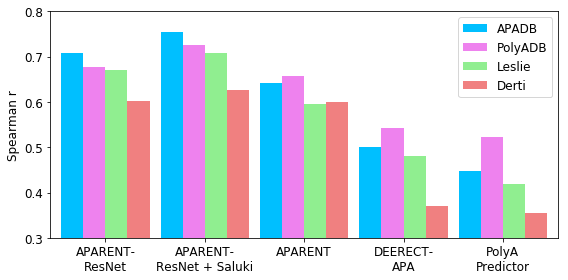

APADB   AP = [0.802, 0.845, 0.754, 0.643, 0.592]
PolyADB AP = [0.756, 0.793, 0.747, 0.612, 0.586]
Leslie  AP = [0.807, 0.841, 0.747, 0.655, 0.59]
Derti   AP = [0.735, 0.756, 0.731, 0.58, 0.558]


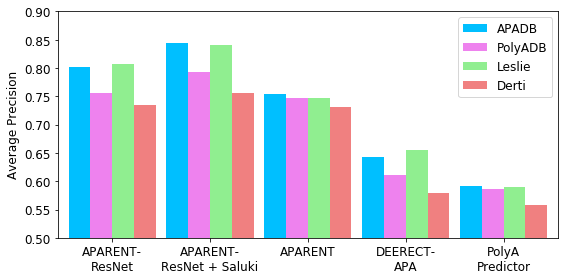

In [21]:

print("APADB   Spearman r = " + str(np.round(model_spearman_rs_apadb, 3).tolist()))
print("PolyADB Spearman r = " + str(np.round(model_spearman_rs_polyadb, 3).tolist()))
print("Leslie  Spearman r = " + str(np.round(model_spearman_rs_leslie, 3).tolist()))
print("Derti   Spearman r = " + str(np.round(model_spearman_rs_derti, 3).tolist()))

f = plt.figure(figsize=(8, 4))

plt.bar(np.arange(model_spearman_rs_apadb.shape[0]) * 4.5, model_spearman_rs_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_spearman_rs_polyadb.shape[0]) * 4.5 + 1, model_spearman_rs_polyadb, width=1., edgecolor='black', color='violet', linewidth=0, label='PolyADB')
plt.bar(np.arange(model_spearman_rs_leslie.shape[0]) * 4.5 + 2, model_spearman_rs_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_spearman_rs_derti.shape[0]) * 4.5 + 3, model_spearman_rs_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 22)
plt.ylim(0.3, 0.8)

plt.xticks([1.5, 6, 10.5, 15, 19.5], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Spearman r', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_and_polyadb_eval_bars_spearman_r.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_and_polyadb_eval_bars_spearman_r.eps")

plt.show()


print("APADB   AP = " + str(np.round(model_aps_apadb, 3).tolist()))
print("PolyADB AP = " + str(np.round(model_aps_polyadb, 3).tolist()))
print("Leslie  AP = " + str(np.round(model_aps_leslie, 3).tolist()))
print("Derti   AP = " + str(np.round(model_aps_derti, 3).tolist()))

f = plt.figure(figsize=(8, 4))

plt.bar(np.arange(model_aps_apadb.shape[0]) * 4.5, model_aps_apadb, width=1., edgecolor='black', color='deepskyblue', linewidth=0, label='APADB')
plt.bar(np.arange(model_aps_polyadb.shape[0]) * 4.5 + 1, model_aps_polyadb, width=1., edgecolor='black', color='violet', linewidth=0, label='PolyADB')
plt.bar(np.arange(model_aps_leslie.shape[0]) * 4.5 + 2, model_aps_leslie, width=1., edgecolor='black', color='lightgreen', linewidth=0, label='Leslie')
plt.bar(np.arange(model_aps_derti.shape[0]) * 4.5 + 3, model_aps_derti, width=1., edgecolor='black', color='lightcoral', linewidth=0, label='Derti')

plt.xlim(-1.0, 22)
plt.ylim(0.5, 0.9)

plt.xticks([1.5, 6, 10.5, 15, 19.5], ['APARENT-\nResNet', 'APARENT-\nResNet + Saluki', 'APARENT', 'DEERECT-\nAPA', 'PolyA\nPredictor'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Average Precision', fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()

plt.savefig("native_apa_multi_w_saluki_dense_cv_20_and_polyadb_eval_bars_ap.png", transparent=True, dpi=300)
plt.savefig("native_apa_multi_w_saluki_dense_cv_20_and_polyadb_eval_bars_ap.eps")

plt.show()
